# PhD Work - Marine Heatwave Pipeline
The following will go through all the necessary steps to obtain useful information on marine heatwaves from sea surface temperature data using ACCESS-OM2-01 as the test case. 

#### NOTE: For `threshold` and `detect` use unstable environment

####       For `block_average` use `analysis3-22-04` or some other older environemnt

This is due to xarray's update causing problems with multi-indexing when unstacking cells back to lat/lon grid. 

In [1]:
# Load required modules
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import scipy as sci
import dask
import cosima_cookbook as cc
import os

# Optional modules
import cmocean as cm

# Ignore warnings
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/42367/status,
Dashboard: /proxy/42367/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41393,Workers: 4
Dashboard: /proxy/42367/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:45619,Total threads: 2
Dashboard: /proxy/43995/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:43003,


In [3]:
# directory setup
exp_name = 'topleft_quad/'
parentdir = '/g/data/v45/jr5971/mhw-analysis/'
workdir = parentdir + exp_name

for i in [parentdir, workdir]:
    try: os.mkdir(workdir)
    except: pass

## Import SST Data

In [4]:
session = cc.database.create_session()

In [5]:
expt = '01deg_jra55v140_iaf'
# vars = cc.querying.get_variables(session, experiment=expt)
# vars[vars['name'].str.lower().str.match('temp')]

Now, in selecting the quadrant we want, we know the whole domain, so let's just divide the lat and lon by 2, and take the top left (i.e., first lon half, second lat half)

In [9]:
%%time
# Find sst data
sst = cc.querying.getvar(expt='01deg_jra55v140_iaf', variable='surface_temp', 
                          session=session, frequency='1 daily', start_time='1990') - 273.15

# whole domain coords
dom_lat = [-48, -10]; dom_lon = [-217, -184]

# top-left quad
lat_cut = np.mean(dom_lat); lon_cut = np.mean(dom_lon)
quad1_sst = sst.sel(yt_ocean=slice(lat_cut, dom_lat[1]), xt_ocean=slice(dom_lon[0], lon_cut))
quad1_sst

CPU times: user 58.4 s, sys: 5.64 s, total: 1min 4s
Wall time: 2min 34s


<xarray.DataArray 'surface_temp' (time: 10684, yt_ocean: 202, xt_ocean: 165)>
dask.array<getitem, shape=(10684, 202, 165), dtype=float32, chunksize=(1, 138, 90), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -216.9 -216.8 -216.7 ... -200.7 -200.6 -200.5
  * yt_ocean  (yt_ocean) float64 -28.94 -28.85 -28.76 ... -10.29 -10.2 -10.1
  * time      (time) datetime64[ns] 1989-10-01T12:00:00 ... 2018-12-31T12:00:00

In [ ]:
%%time
# save for future work
quad1_sst.to_netcdf(workdir + 'quad1_sst.nc')

In [5]:
# sst_tas = xr.open_dataarray(workdir + 'sst_tas.nc')
quad1_sst = xr.open_dataarray(workdir + 'quad1_sst.nc')

NameError: name 'sst' is not defined

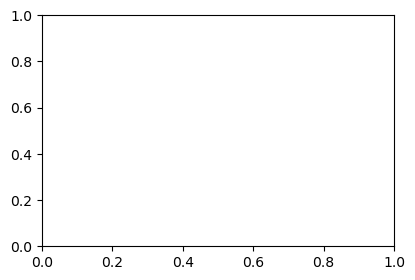

In [6]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1); sst[0,:].plot()
plt.subplot(1,2,2); sst_tas[0,:].plot()

In [ ]:
quad1_sst

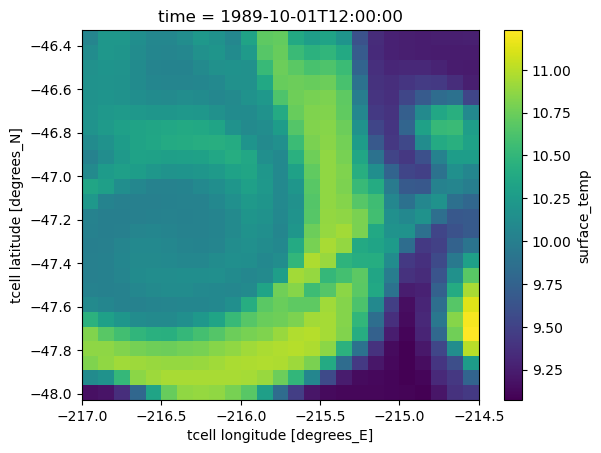

In [13]:
sst_sub = sst_tas.isel(xt_ocean=slice(0,25), yt_ocean=slice(0, 25))
sst_sub[0,:].plot()

In [14]:
sst_sub = sst_sub.chunk(chunks={'time':-1, 'xt_ocean':'auto', 'yt_ocean':'auto'})
sst_sub

<xarray.DataArray 'surface_temp' (time: 10684, yt_ocean: 25, xt_ocean: 25)>
dask.array<xarray-<this-array>, shape=(10684, 25, 25), dtype=float32, chunksize=(10684, 25, 25), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -216.9 -216.8 -216.7 ... -214.7 -214.6 -214.5
  * yt_ocean  (yt_ocean) float64 -47.99 -47.93 -47.86 ... -46.5 -46.43 -46.36
  * time      (time) datetime64[ns] 1989-10-01T12:00:00 ... 2018-12-31T12:00:00

In [15]:
from xmhw.xmhw import threshold, detect

In [16]:
%%time
sst_sub = sst_sub.load()

CPU times: user 3.28 s, sys: 536 ms, total: 3.82 s
Wall time: 28.2 s


In [14]:
%%time
clim = threshold(sst_sub)

calendar not in keys
CPU times: user 1min 19s, sys: 50.8 s, total: 2min 10s
Wall time: 4min 30s


#### ASIDE on efficiency
After several attempts, it seems the best option is to load the data in first, after chunking it such that all time is in the one chunk. 
- On a 5x5 grid, with size 1.02 MiB, the data loads in 1.5mins, and the threshold function takes 10s. 
- On a 5x10 grid with size 2 MB, data loads in 1min, threshold function takes 16s. 
- On a 20x20 grid with size 16 MB, data loads in 1min, threshold function takes 2mins. 
- On a 25x25 grid with size 25 MB, data loads in 1min, threshold function takes 4min 30s. 
    - **Memory maximum of 12.2 GB**

**I also attempted larger grids, e.g., 50x50 however the computation exceeded the available CPU Memory**. This is easy to see why after the memory maximum of the 25x25 reached 12.2GB, and if scaling proportionally, a 50x50 which is 4 times this, would require up to 50 GB of memory!

In [15]:
%%time
clim.to_netcdf(workdir + 'clim.nc')

In [18]:
clim = xr.open_dataset(workdir + 'clim.nc')
clim

<xarray.Dataset>
Dimensions:   (xt_ocean: 25, yt_ocean: 25, doy: 366)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -216.9 -216.8 -216.7 ... -214.7 -214.6 -214.5
  * yt_ocean  (yt_ocean) float64 -47.99 -47.93 -47.86 ... -46.5 -46.43 -46.36
    quantile  float64 ...
  * doy       (doy) int64 1 2 3 4 5 6 7 8 9 ... 359 360 361 362 363 364 365 366
Data variables:
    thresh    (doy, xt_ocean, yt_ocean) float64 ...
    seas      (doy, xt_ocean, yt_ocean) float32 ...
Attributes:
    source:           xmhw code: https://github.com/coecms/xmhw
    title:            Seasonal climatology and threshold calculated to detect...
    history:          2022-12-14: calculated using xmhw code https://github.c...
    xmhw_parameters:  Threshold calculated using:\n    90 percentile;\n    cl...

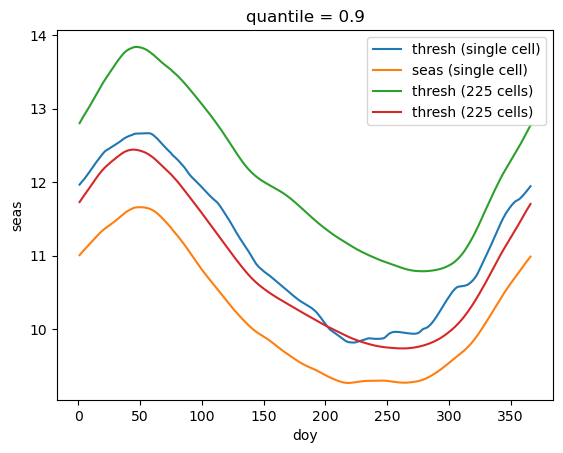

In [19]:
mean_thresh = clim['thresh'].mean(dim=('xt_ocean','yt_ocean'))
mean_seas = clim['seas'].mean(dim=('xt_ocean','yt_ocean'))

clim['thresh'][:,0,0].plot(label='thresh (single cell)')
clim['seas'][:,0,0].plot(label='seas (single cell)')
mean_thresh.plot(label='thresh (225 cells)'); mean_seas.plot(label='thresh (225 cells)')
plt.legend()

Interesting the significant difference in threshold for a single cell compared to the mean

## Detecting MHW events
Now that we have the climatologies we can run detect

### Let's halve the original subsetted grid to see if that helps with the efficiency

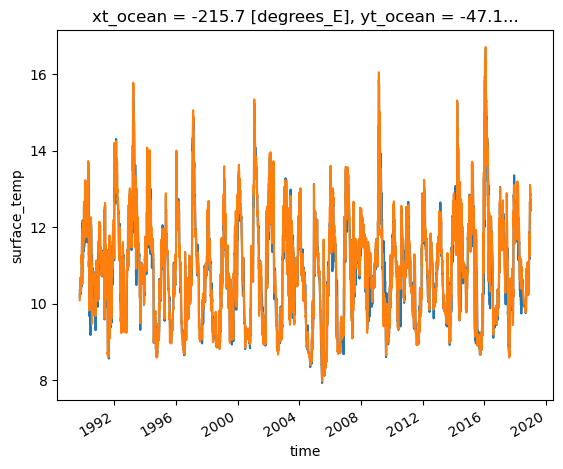

In [22]:
sst_sub1 = sst_sub.isel(xt_ocean=slice(0,12), yt_ocean=slice(0,13))
sst_sub2 = sst_sub.isel(xt_ocean=slice(12,25), yt_ocean=slice(13,25))
sst_sub1[:,12,11].plot(); sst_sub2[:,0,0].plot()

In [24]:
print(f'sst_sub1 size: {sst_sub1.nbytes/1e6}, sst_sub2 size: {sst_sub2.nbytes/1e6}')

sst_sub1 size: 6.666816, sst_sub2 size: 6.666816


Cool, so the two subsets are the same size. Now, let's try the detect function with one of the subsets - perhaps this would be best done with a clean kernel. 

In [25]:
sst_sub1 = sst_sub1.load()

In [27]:
clim['thresh']

<xarray.DataArray 'thresh' (doy: 366, xt_ocean: 25, yt_ocean: 25)>
array([[[11.965111, 12.036829, ..., 13.339975, 13.374126],
        [11.948952, 12.0206  , ..., 13.337547, 13.357211],
        ...,
        [11.970166, 12.018032, ..., 14.085274, 14.097081],
        [12.025284, 12.045063, ..., 14.129404, 14.151862]],

       [[11.987081, 12.057677, ..., 13.368292, 13.402243],
        [11.969715, 12.04135 , ..., 13.366998, 13.386873],
        ...,
        [12.022725, 12.065439, ..., 14.135729, 14.147144],
        [12.078169, 12.090722, ..., 14.178943, 14.201405]],

       ...,

       [[11.920867, 11.992344, ..., 13.27958 , 13.316756],
        [11.908892, 11.978184, ..., 13.277014, 13.297394],
        ...,
        [11.888717, 11.937645, ..., 13.981675, 13.997027],
        [11.944365, 11.967978, ..., 14.029633, 14.054482]],

       [[11.943141, 12.014988, ..., 13.310537, 13.345852],
        [11.928964, 11.999719, ..., 13.307514, 13.327466],
        ...,
        [11.930076, 11.97823 , ..., 14.034192, 14.047793],
        [11.984323, 12.005265, ..., 14.080102, 14.102808]]])
Coordinates:
  * xt_ocean  (xt_ocean) float64 -216.9 -216.8 -216.7 ... -214.7 -214.6 -214.5
  * yt_ocean  (yt_ocean) float64 -47.99 -47.93 -47.86 ... -46.5 -46.43 -46.36
    quantile  float64 ...
  * doy       (doy) int64 1 2 3 4 5 6 7 8 9 ... 359 360 361 362 363 364 365 366
Attributes:
    units:    degree_C

In [29]:
%%time
mhw, intermediate = detect(sst_sub, clim['thresh'], clim['seas'], intermediate=True)
mhw

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xmhw/features.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfout.loc[:,d] = val[0]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xmhw/features.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfout.loc[:,d] = val[0]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xmhw/features.py:157: SettingWithCopyWarning: 
A value is trying to be set o

CPU times: user 19 s, sys: 2.27 s, total: 21.3 s
Wall time: 36.2 s


<xarray.Dataset>
Dimensions:                         (xt_ocean: 25, yt_ocean: 25, events: 4095)
Coordinates:
  * xt_ocean                        (xt_ocean) float64 -216.9 -216.8 ... -214.5
  * yt_ocean                        (yt_ocean) float64 -47.99 -47.93 ... -46.36
  * events                          (events) float64 1.0 2.0 ... 1.067e+04
Data variables: (12/31)
    event                           (events, xt_ocean, yt_ocean) float64 nan ...
    index_start                     (events, xt_ocean, yt_ocean) float64 nan ...
    index_end                       (events, xt_ocean, yt_ocean) float64 nan ...
    time_start                      (events, xt_ocean, yt_ocean) datetime64[ns] ...
    time_end                        (events, xt_ocean, yt_ocean) datetime64[ns] ...
    time_peak                       (events, xt_ocean, yt_ocean) datetime64[ns] ...
    ...                              ...
    intensity_var_relThresh         (events, xt_ocean, yt_ocean) float64 nan ...
    intensity_var_abs               (events, xt_ocean, yt_ocean) float32 nan ...
    category                        (events, xt_ocean, yt_ocean) float64 nan ...
    duration                        (events, xt_ocean, yt_ocean) float64 nan ...
    rate_onset                      (events, xt_ocean, yt_ocean) float64 nan ...
    rate_decline                    (events, xt_ocean, yt_ocean) float64 nan ...
Attributes:
    source:           xmhw code: https://github.com/coecms/xmhw
    title:            Marine heatwave events identified applying the Hobday e...
    history:          2022-12-16: calculated using xmhw code https://github.c...
    xmhw_parameters:  MHW detected using: 5 days of minimum duration;\n      ...

**Notes on Memory**:
- The above cell was executed whilst the memory was at 7.55GB. So if this does exceed the total memory, we might have to just reload the sst_sub and clim datasets. 

Update - halving the `sst_sub` made the detect function work with ease taking about 10 seconds using analysis3-22-10
- Then, using the whole dataset (`sst_sub`), the detect function took only 36 seconds so not sure where the problem was coming from earlier, but it appears we may be able to increase the chunks by more still. 


In [30]:
mhw.to_netcdf(workdir + 'mhw.nc');
intermediate.to_netcdf(workdir + 'intermediate.nc')

## Block average  
##### ****Restart and change to older conda environment****
The blockAverage function calculates statistics along a block of time. Most of the statistics calculated on the block are simple statistics. Given that the mhw properties are saved now as an array it is simple to calculate them after grouping by year or 'bins' of years on the entire dataset. 

In [7]:
clim = xr.open_dataset(workdir+'clim.nc')
mhw = xr.open_dataset(workdir+'mhw.nc')
intermediate = xr.open_dataset(workdir+'intermediate.nc')

In [8]:
from xmhw.identify import land_check
from xmhw.stats import call_groupby, agg_mhw

In [9]:
%%time
blockLength = 1 # Size of block in years
dstime = intermediate # includes original ts and climatologies
period = [dstime.time.dt.year[0].values, 
          dstime.time.dt.year[-1].values,
         ] # absolute value of temperature along time index
# create bins based on blockLength to be used with groupby_bins
bins = range(period[0], period[1] + blockLength + 1, blockLength)

# remove land and stack on cell
mhw = land_check(mhw, tdim="events")

blockls = []
tgroup = mhw["time_start"].isel(cell=0).dt.year
for c in mhw.cell:
    df = mhw.sel(cell=c).to_dataframe()
    
    
    dfbins = pd.cut(tgroup,bins,right=False)

    dfgroup = df.groupby(dfbins).agg(
        ecount=("event", "count"),
        duration=("duration", "mean"),
        intensity_max=("intensity_max", "mean"),
        intensity_max_max=("intensity_max", "max"),
        intensity_mean=("intensity_mean", "mean"),
        intensity_cumulative=("intensity_cumulative", "mean"),
        total_icum=("intensity_cumulative", "sum"),
        intensity_mean_relThresh=("intensity_mean_relThresh", "mean"),
        intensity_cumulative_relThresh=(
            "intensity_cumulative_relThresh",
            "mean",
        ),
        severity_mean=("severity_mean", "mean"),
        severity_cumulative=("severity_cumulative", "mean"),
        intensity_mean_abs=("intensity_mean", "mean"),
        intensity_cumulative_abs=("intensity_cumulative", "mean"),
        rate_onset=("rate_onset", "mean"),
        rate_decline=("rate_decline", "mean"),
    )
    dfblock = dfgroup
    dfblock.index = dfblock.index.to_list()
    dfblock.index.name = "years"
    # convert back to xarray dataset
    block = xr.Dataset.from_dataframe(dfblock, sparse=False)
    blockls.append(block)

block = xr.concat(blockls, dim=mhw.cell).unstack("cell")
    

CPU times: user 23.6 s, sys: 1.43 s, total: 25 s
Wall time: 23.5 s


In [10]:
block

<xarray.Dataset>
Dimensions:                         (years: 30, xt_ocean: 25, yt_ocean: 25)
Coordinates:
  * years                           (years) object [1989, 1990) ... [2018, 2019)
  * xt_ocean                        (xt_ocean) float64 -216.9 -216.8 ... -214.5
  * yt_ocean                        (yt_ocean) float64 -47.99 -47.93 ... -46.36
Data variables: (12/15)
    ecount                          (years, xt_ocean, yt_ocean) int64 3 1 ... 0
    duration                        (years, xt_ocean, yt_ocean) float64 16.67...
    intensity_max                   (years, xt_ocean, yt_ocean) float32 1.53 ...
    intensity_max_max               (years, xt_ocean, yt_ocean) float32 1.743...
    intensity_mean                  (years, xt_ocean, yt_ocean) float32 1.268...
    intensity_cumulative            (years, xt_ocean, yt_ocean) float32 20.85...
    ...                              ...
    severity_mean                   (years, xt_ocean, yt_ocean) float64 -1.38...
    severity_cumulative             (years, xt_ocean, yt_ocean) float64 -23.7...
    intensity_mean_abs              (years, xt_ocean, yt_ocean) float32 1.268...
    intensity_cumulative_abs        (years, xt_ocean, yt_ocean) float32 20.85...
    rate_onset                      (years, xt_ocean, yt_ocean) float64 0.134...
    rate_decline                    (years, xt_ocean, yt_ocean) float64 0.140...

# Splitting large datasets for discretised analyses
Both the threshold and detect functions are setup to use dask delayed automatically. I found this was a good way to make sure the main processes would be automatically run in parallel even if you are not experienced with dask. This approach adds some overhead before the actual calculation starts, when dask is working out the task graph. This is usually negligible, but with a bigger grid size you might end up with too many tasks and a less efficient graph. In that case, and anytime you are working with limited resources, it is more efficient to split the grid and run the code separately for each grid section. You can easily recompose the original grid by concatenating together the resulting datasets. 

Below is an example of running `detect` on a big grid by splitting the grid according to chunks. You can split the grid in different ways and the advantage of this method is that the data will be all in one chunk. So by managing the chunksize you can optimise the amount of memory used. Whichever way you are splitting the grid, make sure that it's somehow aligned with the dataset chunks. 

In [15]:
sst = xr.open_dataarray(workdir+'quad1_sst.nc')
# split the dataset in half again (so we're working with 8ths)
sst_sub1 = sst.isel(xt_ocean=slice(0, len(sst.xt_ocean)//2))
sst_sub2 = sst.isel(xt_ocean=slice(len(sst.xt_ocean)//2, len(sst.xt_ocean)))
sst_sub2
                    
                    


<xarray.DataArray 'surface_temp' (time: 10684, yt_ocean: 202, xt_ocean: 83)>
[179127944 values with dtype=float32]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -208.7 -208.6 -208.5 ... -200.7 -200.6 -200.5
  * yt_ocean  (yt_ocean) float64 -28.94 -28.85 -28.76 ... -10.29 -10.2 -10.1
  * time      (time) datetime64[ns] 1989-10-01T12:00:00 ... 2018-12-31T12:00:00

In [31]:
# Chunk
sst = sst_sub1.chunk({'time':-1, 'xt_ocean':10, 'yt_ocean':-1})
dummy, xt, yt = sst.chunks
xtstep = xt[0]
ytstep = yt[0]
xtblocks = len(xt)
ytblocks = len(yt)
print(xtstep, ytstep, xtblocks, ytblocks)

202 10 1 9


In [32]:
sst

<xarray.DataArray 'surface_temp' (time: 10684, yt_ocean: 202, xt_ocean: 82)>
dask.array<xarray-<this-array>, shape=(10684, 202, 82), dtype=float32, chunksize=(10684, 202, 10), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -216.9 -216.8 -216.7 ... -209.0 -208.9 -208.8
  * yt_ocean  (yt_ocean) float64 -28.94 -28.85 -28.76 ... -10.29 -10.2 -10.1
  * time      (time) datetime64[ns] 1989-10-01T12:00:00 ... 2018-12-31T12:00:00

In [16]:
from xmhw.xmhw import threshold

In [33]:
%%time
sst = sst.load()

CPU times: user 4.55 s, sys: 1.93 s, total: 6.47 s
Wall time: 6.84 s


In [35]:
xtstep

202

In [34]:
%%time
# create an empty list to store the results
# loop first across the ytblocks and then xtblocks
# using xtstep and ytstep to determine the indexes to use with isel

results = []
for i in range(xtblocks):
    xt_from = i*xtstep
    xt_to = (i+1)*xtstep
    for j in range (ytblocks):
        yt_from = j*ytstep
        yt_to = (j+1)*ytstep
        ts = sst.isel(xt_ocean=slice(xt_from,xt_to), yt_ocean=slice(yt_from,yt_to))
        j+=1
        # run function
        results.append(threshold(ts))
        del ts
    i+=1
    


XmhwException: All points of grid are either land or NaN

So, it looks like the above code could work however this first attempt seemed to finish the first loop, then on the second, it ran out of memory - perhaps we could save each one individually? 
Or, we try with a smaller test dataset with less overall chunks. So the steps are:
1. Open sst data array, rechunk and load the data
2. Potentially partition this data (total domain failed initially so this is recommended).
3. Run the above code on the subsetted data to obtain a the seas/thresh data.
4. Setup new loop to run the detect function (with intermediate as TRUE!!!! so we can use the blockAverage function after that)

This is what I'll work on when I next have the chance. 

In [ ]:
%%time
mhw = xr.combine_by_coords(results)
mhw.to_netcdf(workdir+'mhw.nc')

In [ ]:
# create an empty list to store the results
# loop first across the ytblocks and then xtblocks
# using xtstep and ytstep to determine the indexes to use with isel

results = []
for i in range(xtblocks):
    xt_from = i*xtstep
    xt_to = (i+1)*xtstep
    for j in range (ytblocks):
        yt_from = j*ytstep
        yt_to = (j+1)*ytstep
        ts = sst.isel(xt_ocean=slice(xt_from,xt_to), yt_ocean=slice(yt_from,yt_to))
        results.append(threshold(ts))
        
        th = thresh.isel(xt_ocean=slice(xt_from,xt_to), yt_ocean=slice(yt_from,yt_to))
        se = seas.isel(xt_ocean=slice(xt_from,xt_to), yt_ocean=slice(yt_from,yt_to))
        j+=1
        # run function
        results.append(detect(ts,th,se))
        del ts, th, se
    i+=1


The above assumes we have already executed the `threshold` function across the domain, but this could also be implemented in the same fashion - identify roughly the optimum chunk size, where it seemed that the threshold function was the bottleneck, then just do the same to get the larger domain. 

In [8]:
# retrieve chunks information
# xt/yt will be lists - the number of lat/lon points for each chunk
# e.g. [20, 20, 20], [30, 30, 30]
# means we have 20 lat and 30 lon points for each chunk for a total
# of 600 grid cells
# We set these as our "steps"
sst_test = xr.open_dataarray(workdir+'sst_tas.nc')
dummy, xt, yt = sst_test.chunks
xt_step = xt[0]
yt_step = yt[0]
# the length of the list gives the number of chunks
xtblocks = len(xt)
ytblocks = len(yt)
print(xt_step, yt_step, xtblocks, ytblocks)


TypeError: cannot unpack non-iterable NoneType object